<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/image/Image_classification_NSWF_full_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Model https://huggingface.co/google/vit-base-patch16-224-in21k

### From Hugging Face

####Vision Transformer (base-sized model)
Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224. It was introduced in the paper An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale by Dosovitskiy et al. and first released in this repository. However, the weights were converted from the timm repository by Ross Wightman, who already converted the weights from JAX to PyTorch. Credits go to him.

Disclaimer: The team releasing ViT did not write a model card for this model so this model card has been written by the Hugging Face team.

### Model description
The Vision Transformer (ViT) is a transformer encoder model (BERT-like) pretrained on a large collection of images in a supervised fashion, namely ImageNet-21k, at a resolution of 224x224 pixels.

Images are presented to the model as a sequence of fixed-size patches (resolution 16x16), which are linearly embedded. One also adds a [CLS] token to the beginning of a sequence to use it for classification tasks. One also adds absolute position embeddings before feeding the sequence to the layers of the Transformer encoder.

#### Note
This model does not provide any fine-tuned heads, as these were zero'd by Google researchers. However, the model does include the pre-trained pooler, which can be used for downstream tasks (such as image classification).

By pre-training the model, it learns an inner representation of images that can then be used to extract features useful for downstream tasks: if you have a dataset of labeled images for instance, you can train a standard classifier by placing a linear layer on top of the pre-trained encoder. One typically places a linear layer on top of the [CLS] token, as the last hidden state of this token can be seen as a representation of an entire image.

In [ ]:
# blocks output in Colab 💄
%%capture

! pip install datasets transformers
! pip install accelerate wandb bitsandbytes -U -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import wandb

# https://wandb.ai/site

PROJECT = "NSFW-fine_tune"
MODEL_NAME = 'google/vit-base-patch16-224-in21k'
DATASET = "NSFW"
wandb.init(project=PROJECT, # the project I am working on
           tags=[MODEL_NAME, DATASET],
           notes ="Classification Fine Tune NSFW dataset with google/vit-base-patch16-224-in21k") # the Hyperparameters I want to keep track of

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
label_dic={"drawings":0, "hentai": 1,"neutral":2, "porn": 3,"sexy": 4}

In [ ]:
from datasets import ClassLabel, Dataset, Features, Image, Value, Sequence, DatasetDict
from PIL import Image as PImage, ImageOps
import numpy as np
from datasets import load_dataset, load_from_disk
import os

In [ ]:
Clabels= ClassLabel(num_classes=5, names=["drawings", "hentai", "neutral", "porn", "sexy"])

In [ ]:
dataset_path = "/content/drive/MyDrive/data/nsfw_HF_2"

In [ ]:
ds_train = load_from_disk(os.path.join(dataset_path,"train.hf"))
ds_validation = load_from_disk(os.path.join(dataset_path,"validation.hf"))
ds_test = load_from_disk(os.path.join(dataset_path,"test.hf"))

In [ ]:
ds = DatasetDict({"train": ds_train, "validation": ds_validation, "test": ds_test})

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'image_file_path', 'labels'],
        num_rows: 18000
    })
    validation: Dataset({
        features: ['image', 'image_file_path', 'labels'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['image', 'image_file_path', 'labels'],
        num_rows: 5000
    })
})

In [ ]:
ds['train'].features

{'image': Image(decode=True, id=None),
 'image_file_path': Value(dtype='string', id=None),
 'labels': ClassLabel(names=['drawings', 'hentai', 'neutral', 'porn', 'sexy'], id=None)}

In [ ]:
ex = ds['train'][400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x847>,
 'image_file_path': '/content/drive/MyDrive/data/train/drawings/530a2b730aeda68ffe1b7e400a189ef8e837a567298928a0e3752ca7713cf7fa.jpg',
 'labels': 0}

Let's take a look at the image 👀

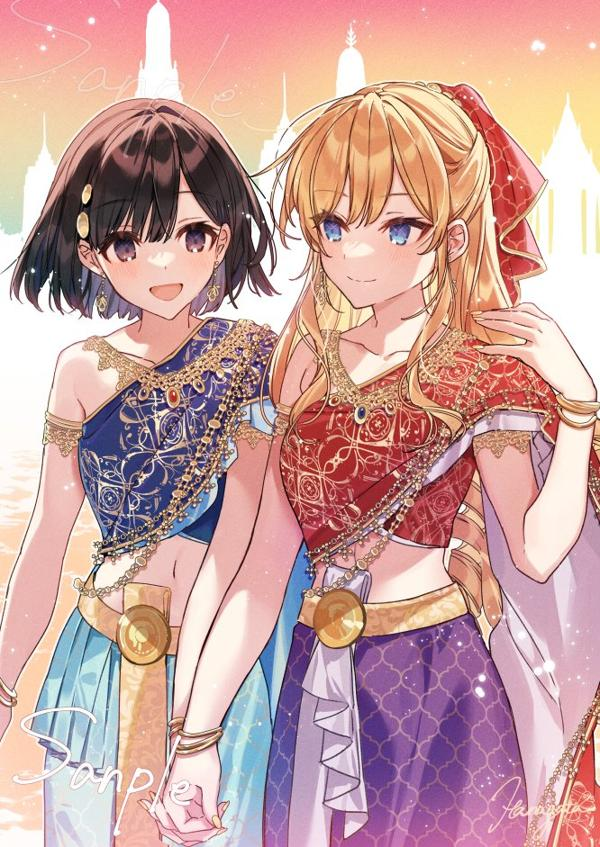

In [ ]:
image = ex['image']
image

In [ ]:
image.size

(600, 847)

In [ ]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['drawings', 'hentai', 'neutral', 'porn', 'sexy'], id=None)

Now, lets print out the class label for our example. We'll do that by using the [`int2str`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) function of `ClassLabel`, which, as the name implies, lets us pass the int representation of the class to look up the string label.

In [ ]:
labels.int2str(ex['labels'])

'drawings'

## Loading ViT Feature Extractor


When ViT models are trained, specific transformations are applied to images being fed into them. Use the wrong transformations on your image and the model won't be able to understand what it's seeing! 🖼 ➡️ 🔢

To make sure we apply the correct transformations, we will use a [`ViTFeatureExtractor`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) model, so lets load its feature extractor from the 🤗 Hub.

In [ ]:
from transformers import ViTFeatureExtractor, ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTImageProcessor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

If we print a feature extractor, we can see its configuration.

In [ ]:
feature_extractor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

To process an image, simply pass it to the feature extractor's call function. This will return a dict containing `pixel values`, which is the numeric representation of your image that we'll pass to the model.

We get a numpy array by default, but if we add the `return_tensors='pt'` argument, we'll get back `torch` tensors instead.


In [ ]:
import matplotlib.pyplot as plt
import torch

In [ ]:
imf = feature_extractor(image, return_tensors='pt')

In [ ]:
imf.keys()

dict_keys(['pixel_values'])

In [ ]:
imf['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [ ]:
tensor_image= imf['pixel_values']

In [ ]:
tensor_image[0].shape

torch.Size([3, 224, 224])

In [ ]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

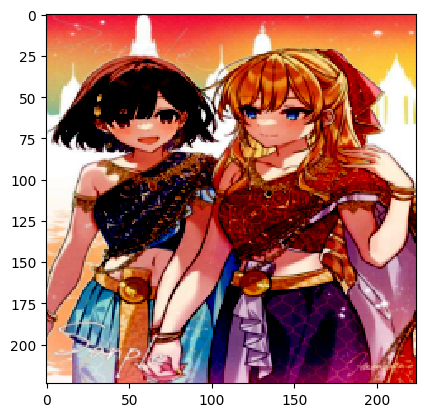

In [ ]:
show(tensor_image[0])

## Processing the Dataset

Now that we know how to read in images and transform them into inputs, let's write a function that will put those two things together to process a single example from the dataset.

In [ ]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [ ]:
ex1 = process_example(ds['train'][0])
ex1.keys()

dict_keys(['pixel_values', 'labels'])

In [ ]:
ex1['labels']

3

While we could call `ds.map` and apply this to every example at once, this can be very slow, especially if you use a larger dataset. Instead, we'll apply a ***transform*** to the dataset. Transforms are only applied to examples as you index them.

First, though, we'll need to update our last function to accept a batch of data, as that's what `ds.with_transform` expects.

In [ ]:


def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

We can directly apply this to our dataset using `ds.with_transform(transform)`.

Now, whenever we get an example from the dataset, our transform will be
applied in real time (on both samples and slices, as shown below)

In [ ]:
prepared_ds['train'][0]

{'pixel_values': tensor([[[-0.0902, -0.0667, -0.1137,  ...,  0.8039,  0.8039,  0.8039],
          [-0.1059, -0.0902, -0.1059,  ...,  0.8039,  0.8039,  0.8039],
          [-0.1294, -0.1373, -0.1216,  ...,  0.8118,  0.8118,  0.8118],
          ...,
          [ 0.2157,  0.2000,  0.1686,  ...,  0.1294,  0.0980,  0.0980],
          [ 0.2549,  0.2235,  0.1686,  ...,  0.0039,  0.0510,  0.0745],
          [ 0.2471,  0.2078,  0.1765,  ..., -0.0667, -0.0353, -0.0118]],
 
         [[ 0.0980,  0.1059,  0.0510,  ...,  0.8275,  0.8275,  0.8275],
          [ 0.0510,  0.0902,  0.0902,  ...,  0.8275,  0.8275,  0.8275],
          [ 0.0118,  0.0510,  0.0980,  ...,  0.8353,  0.8353,  0.8353],
          ...,
          [-0.1059, -0.1137, -0.1294,  ...,  0.1373,  0.1059,  0.1059],
          [-0.0667, -0.0902, -0.1216,  ...,  0.0196,  0.0588,  0.0902],
          [-0.0431, -0.0824, -0.1137,  ..., -0.0431, -0.0039,  0.0196]],
 
         [[ 0.0588,  0.0431, -0.0353,  ...,  0.8667,  0.8667,  0.8667],
          [ 

# Training and Evaluation

The data is processed and we are ready to start setting up the training pipeline. We will make use of 🤗's Trainer, but that'll require us to do a few things first:

- Define a collate function.

- Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. We should define a compute_metrics function accordingly.

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify our images.

### Define our data collator

Batches are coming in as lists of dicts, so we just unpack + stack those into batch tensors.

We return a batch `dict` from our `collate_fn` so we can simply `**unpack` the inputs to our model later. ✨

In [ ]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Define an evaluation metric

Here, we load the [accuracy](https://huggingface.co/metrics/accuracy) metric from `datasets`, and then write a function that takes in a model prediction + computes the accuracy.

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy",trust_remote_code=True)
def compute_metrics(p):

  return  metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-35-3226df1da653>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy",trust_remote_code=True)


Now we can load our pretrained model. We'll add `num_labels` on init to make sure the model creates a classification head with the right number of units. We'll also include the `id2label` and `label2id` mappings so we have human readable labels in the 🤗 hub widget if we choose to `push_to_hub`.

In [ ]:
len(ds['train'].features['labels'].names)

5

In [ ]:
labels = ds['train'].features['labels'].names
id2label={str(i): c for i, c in enumerate(labels)}
label2id={c: str(i) for i, c in enumerate(labels)}
id2label

{'0': 'drawings', '1': 'hentai', '2': 'neutral', '3': 'porn', '4': 'sexy'}

In [ ]:
label2id

{'drawings': '0', 'hentai': '1', 'neutral': '2', 'porn': '3', 'sexy': '4'}

In [ ]:
from transformers import ViTForImageClassification


model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    #ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We're almost ready to train! The last thing we'll do before that is set up the training configuration by defining [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments).

Most of these are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually its ideal to drop unused feature columns, as it makes it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

What I'm trying to say is that you'll have a bad time if you forget to set `remove_unused_columns=False`.

In [ ]:
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-nsfw-224",
  per_device_train_batch_size=16,
  #per_device_eval_batch_size = 64,
  evaluation_strategy="steps",
  num_train_epochs=20,
  fp16=True,
  save_steps=500,
  eval_steps=500,
  logging_steps=10,
  learning_rate=1e-4,
  #warmup_steps=500,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='wandb', # tensorboard
  load_best_model_at_end=True,
)

Now, all instances can be passed to Trainer and we are ready to start training!



In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [ ]:
with wandb.init(project=PROJECT, job_type="train"):
  train_results = trainer.train()
  trainer.save_model()
  # metrics = { "f1":  train_results.metrics}
  # encodedNumpyData = json.dumps(metrics, cls=NumpyArrayEncoder)
  trainer.log_metrics("train", train_results.metrics)
  trainer.save_metrics("train", train_results.metrics)
  trainer.save_state()
  print(train_results.metrics)

Step,Training Loss,Validation Loss,Accuracy
500,0.426200,0.319810,0.883000
1000,0.321600,0.312331,0.889400
1500,0.161700,0.269211,0.911800
2000,0.156400,0.346154,0.892000
2500,0.118700,0.304841,0.916000
3000,0.086000,0.304225,0.922400
3500,0.016100,0.307184,0.920200
4000,0.068700,0.526564,0.891200
4500,0.046800,0.461439,0.899600
5000,0.002400,0.421002,0.913200


***** train metrics *****
  epoch                    =          20.0
  total_flos               = 25981912724GF
  train_loss               =        0.0431
  train_runtime            =    3:20:22.64
  train_samples_per_second =        29.944
  train_steps_per_second   =         1.871
{'train_runtime': 12022.6416, 'train_samples_per_second': 29.944, 'train_steps_per_second': 1.871, 'total_flos': 2.789786636034048e+19, 'train_loss': 0.04311634812752406, 'epoch': 20.0}


eval/accuracy,▁▂▅▂▆▇▆▂▅▄▄▅▅▅▇▅▅▆▇▅▅▃▇▇▆▇▆▇▇▆▇▆▇███████
eval/loss,▂▂▁▂▂▂▂▆▄▅▅▄▅▅▄▅▆▅▅▆▆█▅▆▇▆▇▆▆▇▆▇▆▆▆▆▆▆▆▆
eval/runtime,▇█▆▆▂▆▃▁▃▃▅▄▅▄▅▃▃▅▆▃▂▂▃▂▄▄▃▄▃▂▂▂▃▄▄▂▁▃▂▃
eval/samples_per_second,▂▁▃▃▇▃▅█▆▆▄▅▄▅▄▅▅▄▃▆▇▇▆▇▅▅▆▅▆▇▇▇▆▅▅▇█▆▇▆
eval/steps_per_second,▂▁▃▃▇▃▅█▆▆▄▅▄▅▄▅▅▄▃▆▇▇▆▇▅▅▆▅▆▇▇▇▆▅▅▇█▆▇▆
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▅▃▂▂▁▁▁▂▁▁▂▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


In [ ]:
trainer.state.save_to_json("trainer_state.json")

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
with open("trainer_state.json", "r") as f:
  output = json.load(f)

In [ ]:
steps = []
accs = []
losses = []
for d in output['log_history']:
  if "eval_accuracy" in d.keys():
    step = d.get("step")
    acc = d.get("eval_accuracy")
    loss = d.get("eval_loss")
    steps.append(step)
    accs.append(acc)
    losses.append(loss)


In [ ]:
data =  pd.DataFrame(data=[], columns= ['step', "loss", "accuracy"])

In [ ]:
data['step']= steps
data['loss']= losses
data['accuracy']= accs

In [ ]:
data.head()

,step,loss,accuracy
0,500,0.319810,0.8830
1,1000,0.312331,0.8894
2,1500,0.269211,0.9118
3,2000,0.346154,0.8920
4,2500,0.304841,0.9160


In [ ]:
data['accuracy'].max(), data['loss'].min()

(0.9316, 0.2692112922668457)

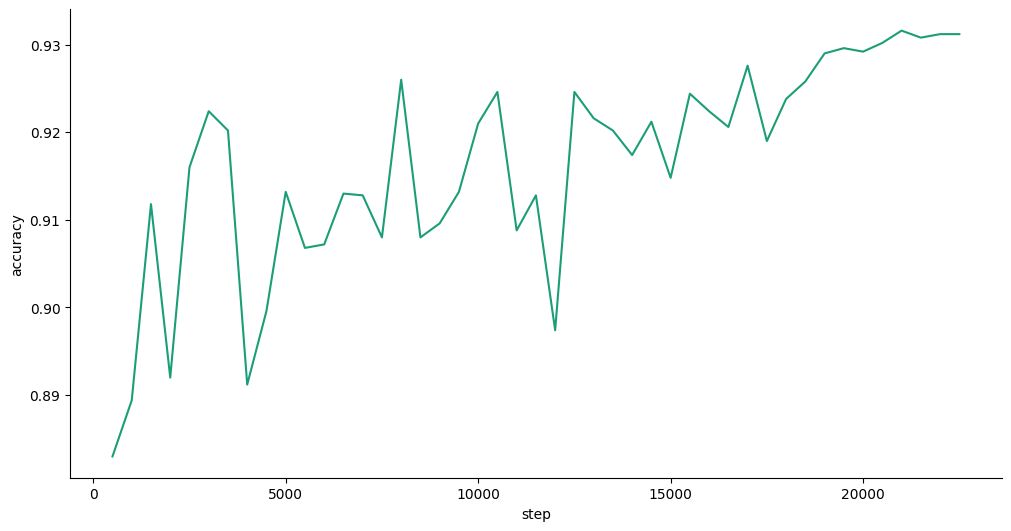

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['step']
  ys = series['accuracy']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('step', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('step')
_ = plt.ylabel('accuracy')

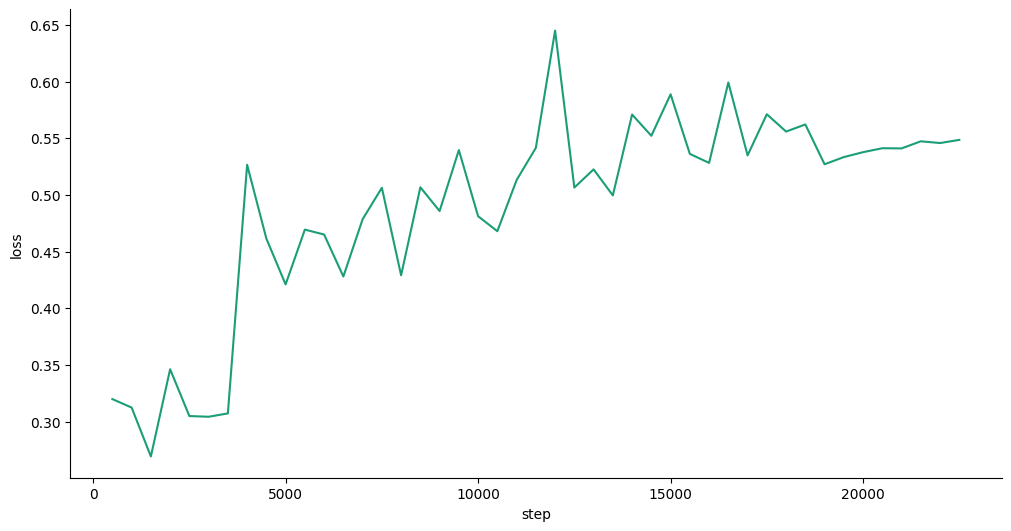

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['step']
  ys = series['loss']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('step', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('step')
_ = plt.ylabel('loss')

In [ ]:
print(train_results.metrics)

{'train_runtime': 12022.6416, 'train_samples_per_second': 29.944, 'train_steps_per_second': 1.871, 'total_flos': 2.789786636034048e+19, 'train_loss': 0.04311634812752406, 'epoch': 20.0}


In [ ]:
with wandb.init(project=PROJECT, job_type="dataset"):
   wbtrain = wandb.Table(data=data)

   wandb.log({"metrics": wbtrain})


wandb: Currently logged in as: olonok (olonok69). Use `wandb login --relogin` to force relogin


In [ ]:
with wandb.init(project=PROJECT, job_type="evaluation"):
  metrics = trainer.evaluate(prepared_ds['test'])
  trainer.log_metrics("eval", metrics)
  trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       20.0
  eval_accuracy           =     0.9172
  eval_loss               =     0.2567
  eval_runtime            = 0:01:23.60
  eval_samples_per_second =     59.802
  eval_steps_per_second   =      7.475


eval/accuracy,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/accuracy,0.9172
eval/loss,0.25669
eval/runtime,83.6089
eval/samples_per_second,59.802


In [ ]:
metrics

{'eval_loss': 0.25669142603874207,
 'eval_accuracy': 0.9172,
 'eval_runtime': 83.6089,
 'eval_samples_per_second': 59.802,
 'eval_steps_per_second': 7.475,
 'epoch': 20.0}

In [ ]:
trainer.state.best_model_checkpoint

'./vit-base-nsfw-224/checkpoint-1500'

In [ ]:
trainer.state.best_model_checkpoint
!mkdir nsfw_model
custom_path = "./nsfw_model/"
trainer.save_model(output_dir=custom_path)

In [ ]:
with wandb.init(project=PROJECT, job_type="models"):
  artifact = wandb.Artifact("nsfw_3600", type="model")
  artifact.add_dir(custom_path)
  wandb.save(custom_path)
  wandb.log_artifact(artifact)

wandb: Adding directory to artifact (./nsfw_model)... Done. 1.0s


In [ ]:
wandb.finish()